In [ ]:
!pip install keras_tuner

In [ ]:
# imports 
# always run this cell
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras import backend as K
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
import seaborn as sn
import pandas as pd


In [ ]:
# import the MNIST dataset

(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()

# scale the data in range [0,1]
Xtrain = Xtrain.astype('float32') / 255.0
Xtest = Xtest.astype('float32') / 255.0

num_classes = 10

# we need to one hot encoding the target values, to help the training process of neural network
# we will use cross entropy loss function so we must represent the target values as one hot encoding vectors according to keras documentation
ytrain_onehot = keras.utils.to_categorical(ytrain,num_classes)
ytest_onehot = keras.utils.to_categorical(ytest,num_classes)



In [ ]:
# hyperparameters tuning using grid search with 5 fold cross validation
# IT TAKES SO LONG TO RUN
# SO WE WILL USE KERAS TUNER Hyperband for hyperparameters tuning as we see in class

# need these custom functions to compute f1_score
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision_score = precision(y_true, y_pred)
    recall_score = recall(y_true, y_pred)
    return 2*((precision_score*recall_score)/(precision_score+recall_score+K.epsilon()))


def model_builder(hp):
    #define hyperparameters
    hp_n1=hp.Choice('n1', values=[64, 128])
    hp_n2=hp.Choice('n2', values=[256, 512])
    hp_a=hp.Choice('a', values=[0.1, 0.001, 0.000001])
    hp_lr=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])

    # define the general model
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(hp_n1, activation='relu',kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(hp_a))) # hidden layer 1 fully connected
    model.add(Dense(hp_n2, activation='relu',kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(hp_a))) # hidden layer 2 fully connected
    model.add(Dense(10, activation='softmax',kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(hp_a))) # output layer
    model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer = keras.optimizers.RMSprop(learning_rate=hp_lr), metrics=['accuracy', f1])
    return model


#Using Hyperband 
tuner = kt.Hyperband(model_builder, objective=kt.Objective('val_f1', direction = 'max'),max_epochs=1000)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)
tuner.search(Xtrain, ytrain_onehot, epochs=1000, validation_split=0.2, callbacks=[early_stop])
# get the best model
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("best models hyperparameters : n1=%d n2=%d a=%f learning_rate=%f" % (best_hps.get('n1'), best_hps.get('n2'), best_hps.get('a'), best_hps.get('learning_rate')))




# Grid search
# # grid search parameters
# nh1 = [64, 128] # number of neurons in hidden layer1
# nh2 = [256, 512] # number of neurons in hidden layer2
# a_l2 = [0.1, 0.001, 0.000001] # a parameter for l2 regularization
# learning_rate = [0.1, 0.01, 0.001] # learning rate in rmsprop optimizer

# earlystop = keras.callbacks.EarlyStopping(monitor='val_f1', patience=200) # define early stopping to help the training process of mlp
# f1_mean = [] # store the f1_mean of every model 
# accuracy_mean = [] # store accuracy mean of every model
# precision_mean = []
# recall_mean = []
# hyperparameters = [] # store the hyperparameters, every row corresponds to a model and a f1_mean value

#cv = KFold(n_splits=5)

# for n1 in nh1:
#   for n2 in nh2:
#     for a in a_l2:
#       for lr in learning_rate:
#         f1_score = []
#         accuracy = []
#         precision_score = []
#         recall_score = []
#         for train_indices, test_indices in cv.split(Xtrain):
#           # define the train and test data for every iteration of cross validation 
#           x_train, x_test = Xtrain[train_indices], Xtrain[test_indices]
#           y_train, y_test = ytrain_onehot[train_indices], ytrain_onehot[test_indices]
#           # define the model we test
#           model = Sequential()
#           model.add(Flatten(input_shape=(28, 28)))
#           model.add(Dense(n1, activation='relu',kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(a))) # hidden layer 1 fully connected
#           model.add(Dense(n2, activation='relu',kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(a))) # hidden layer 2 fully connected
#           model.add(Dense(10, activation='softmax',kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(a))) # output layer
#           model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer = keras.optimizers.RMSprop(learning_rate=lr), metrics=['accuracy', f1, precision, recall])
#           history = model.fit(x_train,y_train, batch_size = 256, epochs = 1000, validation_data = (x_test,y_test), callbacks = [earlystop]) 
#           f1_score.append(max(history.history['val_f1']))
#           accuracy.append(max(history.history['val_accuracy']))
#           recall_score.append(max(history.history['val_recall']))
#           precision_score.append(max(history.history['val_precision']))
  
#         f1_mean.append(np.mean(f1_score))
#         accuracy_mean.append(np.mean(accuracy))
#         recall_mean.append(np.mean(recall_score))
#         precision_mean.append(np.mean(precision_score))
#         hyperparameters.append((n1,n2,a,lr))

# max_index = np.argmax(f1_mean)
# print(f1_mean)
# print(accuracy_mean)
# print(precision_mean)
# print(recall_mean)
# print("best model F-score is: ",f1_mean[max_index])
# print("Hyperparameters of best model: nh1 = "+str(hyperparameters[max_index][0])+", nh2 = "+str(hyperparameters[max_index][1])+", a = "+str(hyperparameters[max_index][2])+", lr = "+str(hyperparameters[max_index][3]))


Trial 30 Complete [00h 00m 11s]
val_f1: 0.0

Best val_f1 So Far: 0.9678891897201538
Total elapsed time: 00h 07m 03s
best models hyperparameters : n1=128 n2=512 a=0.000001 learning_rate=0.001000


Epoch 1/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.3611 - accuracy: 0.8935 - f1: 0.8803 - val_loss: 0.2020 - val_accuracy: 0.9419 - val_f1: 0.9434
Epoch 2/1000
188/188 [==============================] - 2s 12ms/step - loss: 0.1504 - accuracy: 0.9558 - f1: 0.9563 - val_loss: 0.1896 - val_accuracy: 0.9404 - val_f1: 0.9400
Epoch 3/1000
188/188 [==============================] - 3s 18ms/step - loss: 0.1040 - accuracy: 0.9685 - f1: 0.9689 - val_loss: 0.1145 - val_accuracy: 0.9659 - val_f1: 0.9666
Epoch 4/1000
188/188 [==============================] - 4s 19ms/step - loss: 0.0762 - accuracy: 0.9764 - f1: 0.9768 - val_loss: 0.1020 - val_accuracy: 0.9694 - val_f1: 0.9705
Epoch 5/1000
188/188 [==============================] - 4s 23ms/step - loss: 0.0597 - accuracy: 0.9821 - f1: 0.9822 - val_loss: 0.0882 - val_accuracy: 0.9749 - val_f1: 0.9749
Epoch 6/1000
188/188 [==============================] - 4s 21ms/step - loss: 0.0471 - accuracy: 0.9859 - f1: 0.9861 - val_los

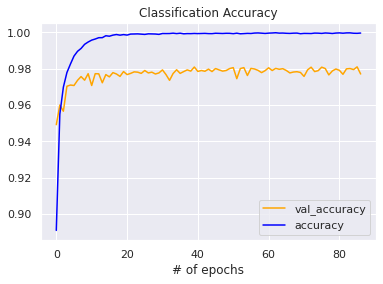

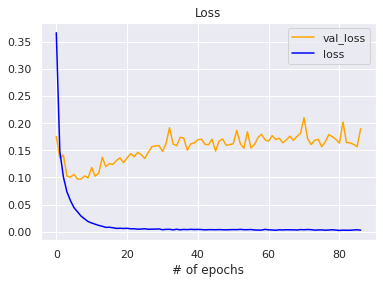

In [ ]:
# best model
# find optimal number of epochs for which to train best model 
model = tuner.hypermodel.build(best_hps)
history = model.fit(Xtrain, ytrain_onehot,batch_size=256, epochs=1000, validation_split=0.2)
val_f1_per_epoch = history.history['val_accuracy']
best_epoch = val_f1_per_epoch.index(max(val_f1_per_epoch)) + 1
print("The optimal number of epochs is", best_epoch)

# we retrain the best model for optimal number of epochs 
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(Xtrain, ytrain_onehot, batch_size=256, epochs=best_epoch, validation_split=0.2)

# plot accuracy 
plt.figure() 
plt.title('Classification Accuracy')
plt.plot(history.history['val_accuracy'],color='orange',label='validation')
plt.plot(history.history['accuracy'],color='blue',label='train')
plt.xlabel('# of epochs')
plt.legend(['val_accuracy', 'accuracy'])
# plot learning curve
plt.figure()
plt.title('Loss')
plt.plot(history.history['val_loss'],color='orange',label='validation')
plt.plot(history.history['loss'],color='blue',label='train')
plt.xlabel('# of epochs')
plt.legend(['val_loss', 'loss'])




In [ ]:
# evaluation of model in unseen test data set
ypred = hypermodel.predict(Xtest) # Predictions of best model on unseen test set
conf_matrix = confusion_matrix(ytest, ypred.argmax(axis=1)) # ypred needs to be in the same form as ytest : 1d array with class predictions
classes = ['0', '1','2','3','4','5','6','7','8','9']
df_conf_matrix = pd.DataFrame(conf_matrix, classes,classes)
print("Classification report:\n",classification_report(ytest, ypred.argmax(axis=1), target_names=classes))
print("Confusion matrix where rows are true labels and columns are predicted classes: \n")
df_conf_matrix



Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.97      0.97      0.97       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.97      0.98       974
           9       0.95      0.99      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confusion matrix where rows are true labels and columns are predicted classes: 



,0,1,2,3,4,5,6,7,8,9
0,970,1,1,0,0,0,4,0,1,3
1,0,1130,1,0,0,1,1,1,1,0
2,1,1,1013,2,3,0,1,7,4,0
3,3,3,6,976,0,5,0,6,1,10
4,1,1,1,1,953,0,4,3,2,16
5,4,0,0,3,2,864,8,3,4,4
6,4,2,1,1,10,1,939,0,0,0
7,1,2,11,1,2,0,0,1000,2,9
8,3,1,2,4,5,2,2,4,946,5
9,2,4,0,1,4,0,1,3,0,994
